# Importing Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

%matplotlib inline

# Loading and Transforming Data

In [2]:
# Define image transformation
torch.manual_seed(0)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

In [3]:
# Create loaders for transformed image data
train_data = torchvision.datasets.FashionMNIST(root="../data", train=True, download=True, transform=img_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)

test_data = torchvision.datasets.FashionMNIST(root="../data", train=False, download=True, transform=img_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60, shuffle=False)

# Visualizing Data

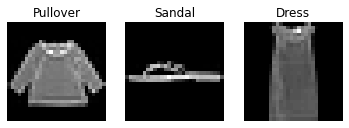

In [4]:
labels_map = {
    0: "T-shirt / top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig = plt.figure()

for i in range(3):
    img, label = train_data[torch.randint(high=len(train_data)-1, size=(1,)).item()]
    fig.add_subplot(1, 3, i + 1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

# Creating Model

In [5]:
# set up GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
# Set up FNN
class FeedForwardNeuralNetwork(nn.Module):
  def __init__(self):
    super(FeedForwardNeuralNetwork, self).__init__()

    self.flatten = nn.Flatten()

    self.linear_stack = nn.Sequential(
        nn.Linear(28 * 28, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
  
  def forward(self, x):
    x = self.linear_stack(self.flatten(x))
    return x

In [7]:
# Create instance of model on GPU
model = FeedForwardNeuralNetwork()
model.to(device)

FeedForwardNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [8]:
# Choose loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
# Train model for one epoch
def train_one_epoch(model, loader, loss_fn, optimizer, device):
  for batch, (inputs, labels) in enumerate(loader):
    # Move training data to GPU
    inputs, labels = inputs.to(device), labels.to(device)

    # Predict and compute loss
    labels_pred = model(inputs)
    loss = loss_fn(labels_pred, labels)

    # Backpropagation to learn weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print(f"Loss: {loss.item():>7f} [{batch*len(inputs):>5d} / {len(loader.dataset):>5d}]")
  
  return loss.item()

In [10]:
# Test model for one epoch
def test_one_epoch(model, loader, loss_fn, device):
  with torch.no_grad():
    running_loss = 0
    running_correct = 0

    for batch, (inputs, labels) in enumerate(loader):
      # Move training data to GPU
      inputs, labels = inputs.to(device), labels.to(device)

      # Predict and compute loss
      labels_pred = model(inputs)

      # Add to running loss
      loss = loss_fn(labels_pred, labels)
      running_loss += loss

      # Add to running correct count
      correct = (labels_pred.argmax(1) == labels).type(torch.float).sum().item()
      running_correct += correct
      
    print(f"\nAvg. Validation Loss: {running_loss/len(loader):>7f}")
    print(f"Validation Accuracy: {running_correct/len(loader.dataset)*100:>2f}%\n")

    return running_loss/len(loader), running_correct/len(loader.dataset)*100

In [11]:
# Number of epochs
epochs = 10

# Training loop
train_loss = []
test_loss = []

start_time = time.time()
for epoch in range(epochs):
  print(f"--------------------\nEPOCH: {epoch+1}\n--------------------")
  train_loss.append(train_one_epoch(model, train_loader, loss_fn, optimizer, device))
  test_loss.append(test_one_epoch(model, test_loader, loss_fn, device))
  print(f"Time: {time.time()-start_time:>2f} seconds\n")

# Save model
print("Saving model...")
torch.save(model, "../trained_models/fnn_fashion_mnist")

print("Done!")

--------------------
EPOCH: 1
--------------------
Loss: 2.295656 [    0 / 60000]
Loss: 1.851956 [ 6000 / 60000]
Loss: 1.484009 [12000 / 60000]
Loss: 1.081764 [18000 / 60000]
Loss: 0.968114 [24000 / 60000]
Loss: 0.743843 [30000 / 60000]
Loss: 0.682334 [36000 / 60000]
Loss: 0.616834 [42000 / 60000]
Loss: 0.600952 [48000 / 60000]
Loss: 0.775839 [54000 / 60000]

Avg. Validation Loss: 0.630898
Validation Accuracy: 76.890000%

Time: 23.887780 seconds

--------------------
EPOCH: 2
--------------------
Loss: 0.429591 [    0 / 60000]
Loss: 0.602837 [ 6000 / 60000]
Loss: 0.630178 [12000 / 60000]
Loss: 0.707261 [18000 / 60000]
Loss: 0.514489 [24000 / 60000]
Loss: 0.430944 [30000 / 60000]
Loss: 0.463064 [36000 / 60000]
Loss: 0.571535 [42000 / 60000]
Loss: 0.466130 [48000 / 60000]
Loss: 0.627953 [54000 / 60000]

Avg. Validation Loss: 0.527568
Validation Accuracy: 80.650000%

Time: 48.408905 seconds

--------------------
EPOCH: 3
--------------------
Loss: 0.487690 [    0 / 60000]
Loss: 0.572954 [

# Visualizing Training Results

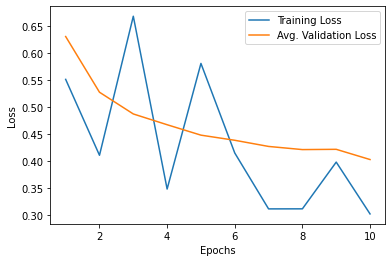

In [12]:
# Plot training and validation loss against epochs
plt.plot([i+1 for i in range(epochs)], train_loss, label="Training Loss")
plt.plot([i+1 for i in range(epochs)], [loss[0].item() for loss in test_loss], label="Avg. Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

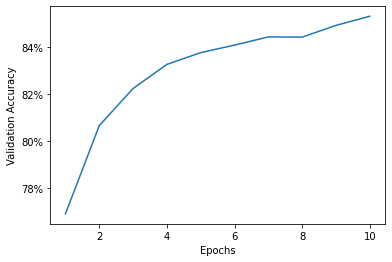

In [13]:
# Plot validation accuracy of model against epochs
_, ax = plt.subplots()
plt.plot([i+1 for i in range(epochs)], [loss[1] for loss in test_loss])

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

plt.show()